In [1]:
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import csv
import ast
from brokenaxes import brokenaxes

In [2]:
# find all CSVs one level up (kernel-survey)
csv_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
csv_files = glob.glob(os.path.join(csv_dir, '*.csv'))

# read each csv, tag with its filename, collect into a list
dfs = []
for path in csv_files:
    df = pd.read_csv(path, quotechar='"', quoting=csv.QUOTE_NONNUMERIC)
    df['filename'] = os.path.basename(path)
    dfs.append(df)

# concatenate all dataframes
df = pd.concat(dfs, ignore_index=True)

# now you can explore or visualize
print(df.shape)
print(df.columns)

(301, 43)
Index(['source_code', 'combined_name', 'kernel_name', 'exec_args', 'grid_size',
       'block_size', 'total_num_threads', 'empirical_sp_flop_count',
       'empirical_dp_flop_count', 'src_concretized_input_args',
       'step1_messages', 'concretizationState', 'src_single_kernel_execution',
       'step2_messages', 'srcSingleKernelState',
       'snippet_first_kernel_invocation', 'snippet_kernel_src',
       'snippet_kernel_src_concretized_values', 'step5_messages',
       'snippetConcretizationState', 'kernel_annotated_warp_divergence',
       'kernel_annotated_WDPs', 'wdps_list', 'wdp_processing_index',
       'wdps_num_executions', 'kernel_annotated_num_ops', 'step8_messages',
       'numOpsAnnotationState', 'summed_kernel_ops', 'sp_flop_diff',
       'dp_flop_diff', 'sp_flop_perc_diff', 'dp_flop_perc_diff',
       'input_tokens', 'output_tokens', 'total_cost', 'trial', 'modelName',
       'top_p', 'temp', 'totalQueryTime', 'error', 'filename'],
      dtype='object')


In [3]:
def classify_success(error_str):
    if error_str is np.nan:
        return 'Success'
    elif "QUERY TIMEOUT EVENT" in error_str:
        return 'Timeout'
    else:
        return 'Failed'

def sum_costs(cost_str):
    if cost_str is np.nan:
        return 0
    else:
        return sum(float(x) for x in ast.literal_eval(cost_str)) 

# add a success column
df['success'] = df['error'].apply(classify_success)
df['totalQueryTime'] = df['totalQueryTime'].astype(float)
df['total_query_cost'] = df['total_cost'].apply(sum_costs)

In [4]:
success_df = df[df['success'] == 'Success']

In [5]:
from dataclasses import dataclass
import re, ast

@dataclass
class FLOPCounts:
    sp_flop_count: int
    sp_flop_explanation: str
    dp_flop_count: int
    dp_flop_explanation: str

# only match our four fields
_flop_pattern = re.compile(
    r"(sp_flop_count|sp_flop_explanation|dp_flop_count|dp_flop_explanation)"
    r"=('(?:[^']*)'|\d+)"
)

def parse_flop_counts(ops_str):
    matches = _flop_pattern.findall(ops_str)
    d = {}
    for k, v in matches:
        if v.startswith("'"):
            d[k] = ast.literal_eval(v)
        else:
            d[k] = int(v)
    # fill in defaults in case any key is missing
    out = FLOPCounts(
        sp_flop_count       = d.get("sp_flop_count", 0),
        sp_flop_explanation = d.get("sp_flop_explanation", ""),
        dp_flop_count       = d.get("dp_flop_count", 0),
        dp_flop_explanation = d.get("dp_flop_explanation", "")
    )
    return out

success_df['flop_counts'] = (
    success_df['summed_kernel_ops']
      .apply(parse_flop_counts)
)

success_df['sp_flop_predicted'] = success_df['flop_counts'].apply(lambda x: x.sp_flop_count)
success_df['sp_flop_explanation'] = success_df['flop_counts'].apply(lambda x: x.sp_flop_explanation)
success_df['dp_flop_predicted'] = success_df['flop_counts'].apply(lambda x: x.dp_flop_count)
success_df['dp_flop_explanation'] = success_df['flop_counts'].apply(lambda x: x.dp_flop_explanation)

/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_16746/2083037434.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  success_df['flop_counts'] = (
/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_16746/2083037434.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  success_df['sp_flop_predicted'] = success_df['flop_counts'].apply(lambda x: x.sp_flop_count)
/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_16746/2083037434.py:40: SettingWithCopyWarning: 
A value is trying to be

In [6]:
nnz_sp_flop_df = success_df[success_df['empirical_sp_flop_count'] > 0]

nnz_dp_flop_df = success_df[success_df['empirical_dp_flop_count'] > 0]

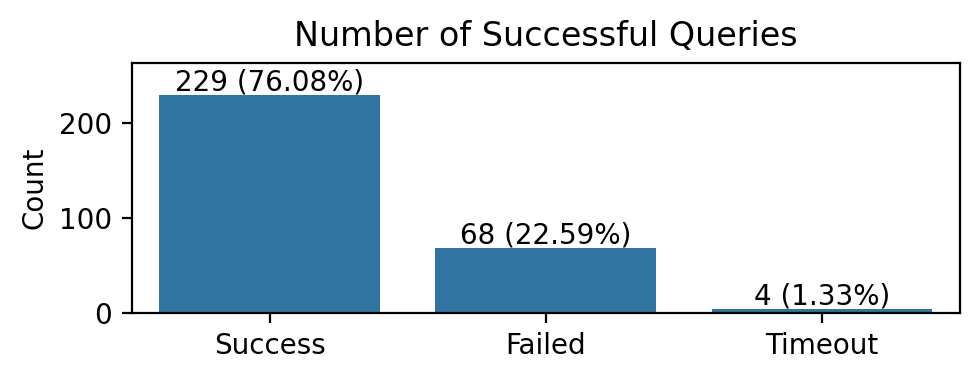

In [7]:
# make a seaborn plot showing the number of successful and not-successful elements in the df

plt.figure(figsize=(5, 2), dpi=200)
ax = sns.countplot(x='success', data=df)

# adjust y-limit so annotations fit
max_count = df['success'].value_counts().max()
ax.set_ylim(0, max_count * 1.15)

# add count labels on top of each bar
for p in ax.patches:
    count = int(p.get_height())
    percent = count / len(df) * 100
    ax.text(
        p.get_x() + p.get_width() / 2,
        p.get_height() + max_count * 0.02,
        f"{count} ({percent:.2f}%)",
        ha='center'
    )

#plt.xlabel('Outcome')
plt.xlabel('')
plt.ylabel('Count')
plt.title('Number of Successful Queries')
#plt.xticks([0, 1], ['Failed', 'Successful'])
plt.tight_layout()
plt.show()

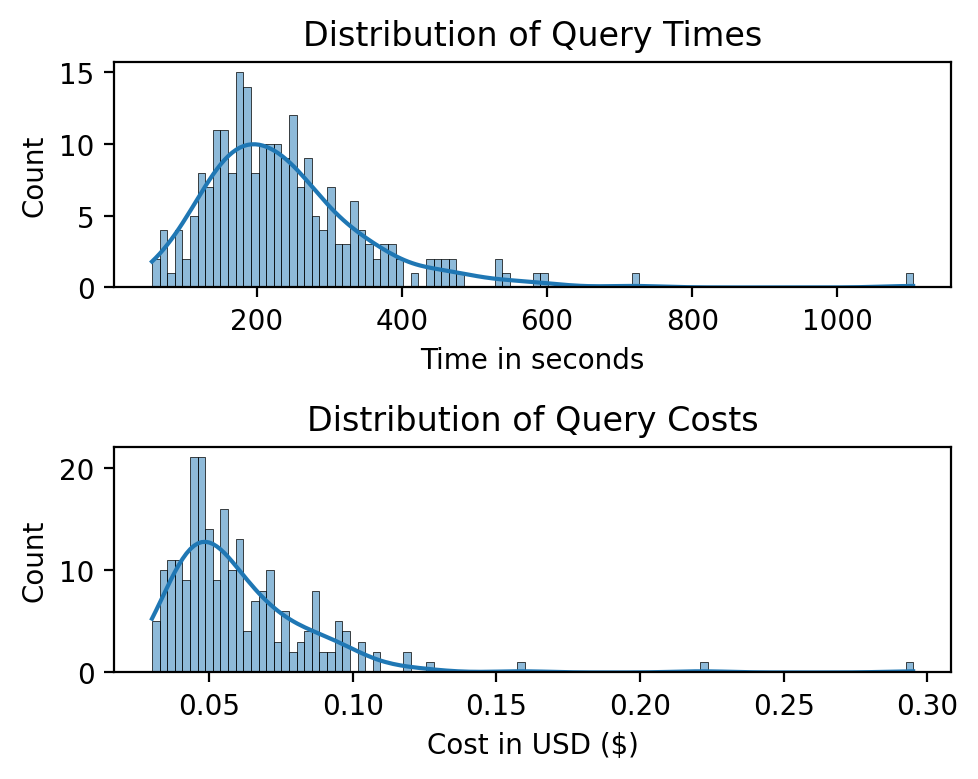

In [8]:
# now let's check the distribution of the query times and costs on two axes
bins = 100
fig, (ax1, ax2) = plt.subplots(2, 1,
                               figsize=(5, 4),  # taller to fit both
                               dpi=200,
                               sharex=False)   # you can set True if you want to share x
sns.histplot(success_df['totalQueryTime'], bins=bins, kde=True, ax=ax1)
ax1.set_title('Distribution of Query Times')
ax1.set_xlabel('Time in seconds')
ax1.set_ylabel('Count')

sns.histplot(success_df['total_query_cost'], bins=bins, kde=True, ax=ax2)
ax2.set_title('Distribution of Query Costs')
ax2.set_xlabel('Cost in USD ($)')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()

Covariance matrix:
 [[ 1.41927031e-10 -3.40769027e-08]
 [-3.40769027e-08  1.02505291e-05]]


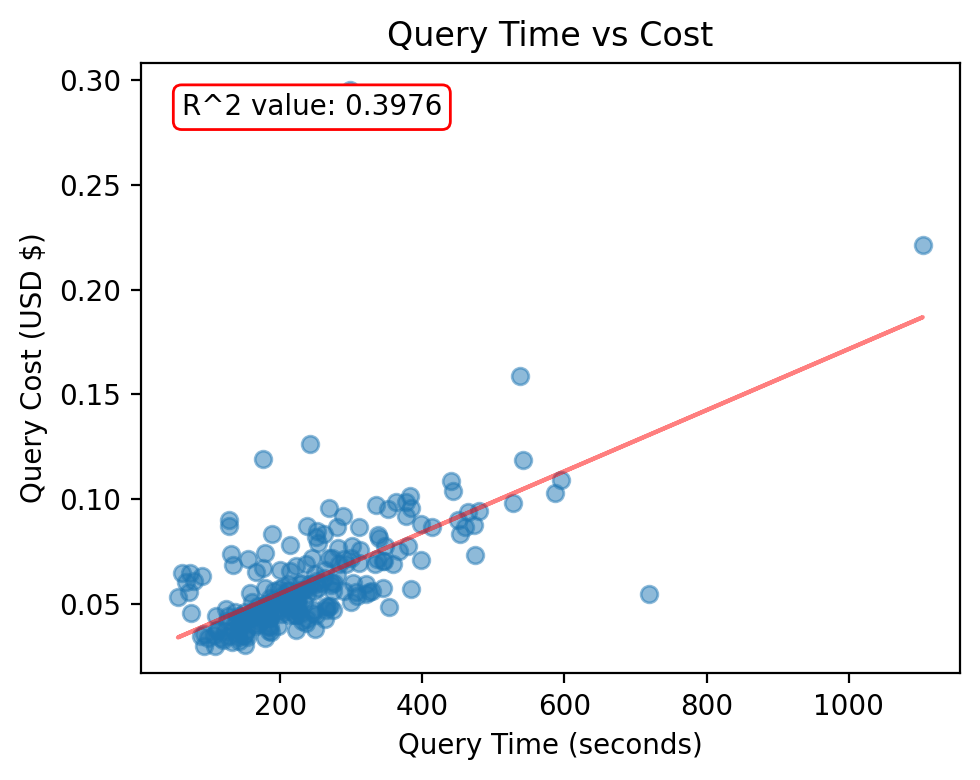

In [9]:
# scatter plot of query time vs cost
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=200)
ax.scatter(success_df['totalQueryTime'], success_df['total_query_cost'], alpha=0.5)

# display a line of best fit
z, cov = np.polyfit(success_df['totalQueryTime'],
                    success_df['total_query_cost'],
                    deg=1, cov=True)
p = np.poly1d(z)
x = success_df['totalQueryTime'].values
predicted = p(x)
ax.plot(x, predicted, color='red', alpha=0.5)

# print the R^2 value on the plot
r_squared = np.corrcoef(success_df['totalQueryTime'], success_df['total_query_cost'])[0, 1] ** 2
ax.text(0.05, 0.95, f"R^2 value: {r_squared:.4f}", transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='red', facecolor='white'))

## compute per-point standard error of the prediction
#var_m = cov[0, 0]
#var_b = cov[1, 1]
#cov_mb = cov[0, 1]
#sigma_pred = np.sqrt(var_b + x**2 * var_m + 2 * x * cov_mb)
#
## 95% confidence band
#upper = predicted + 1.96 * sigma_pred
#lower = predicted - 1.96 * sigma_pred
#ax.fill_between(x, lower, upper, color='red', alpha=0.2)

print("Covariance matrix:\n", cov)

ax.set_xlabel('Query Time (seconds)')
ax.set_ylabel('Query Cost (USD $)')
ax.set_title('Query Time vs Cost')
plt.tight_layout()
plt.show()

/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_16746/2697845105.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


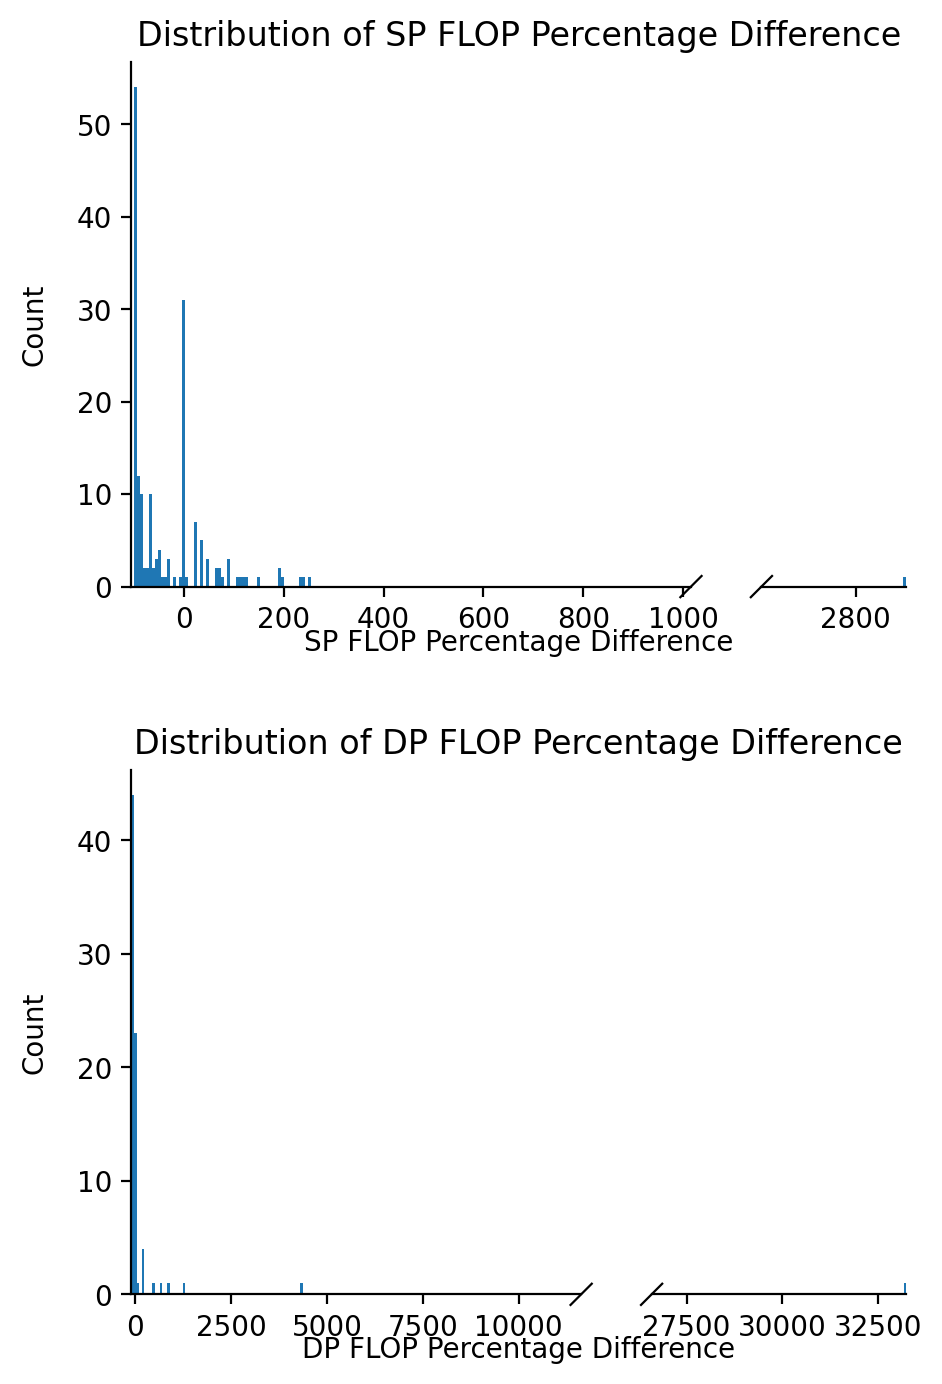

In [10]:
# compute the full tails

sp_min = nnz_sp_flop_df['sp_flop_perc_diff'].min()
dp_min = nnz_dp_flop_df['dp_flop_perc_diff'].min()

sp_max = nnz_sp_flop_df['sp_flop_perc_diff'].max()
dp_max = nnz_dp_flop_df['dp_flop_perc_diff'].max()

fig = plt.figure(figsize=(5, 8), dpi=200)
bins = 500
# layout 2 rows stacked
gs = fig.add_gridspec(2, 1, height_ratios=[1, 1], hspace=0.35)

# SP plot with broken x-axis: zoom in to [-1,1] then skip to the upper tail
ax1 = brokenaxes(xlims=((sp_min*1.05, sp_max*0.35), (sp_max*0.9, sp_max)),
                 subplot_spec=gs[0],
                 hspace=0.05)
ax1.hist(nnz_sp_flop_df['sp_flop_perc_diff'], bins=bins)
ax1.set_title('Distribution of SP FLOP Percentage Difference')
ax1.set_xlabel('SP FLOP Percentage Difference')
ax1.set_ylabel('Count')

# DP plot, same idea
ax2 = brokenaxes(xlims=((dp_min*1.05, dp_max*0.35), (dp_max*0.8, dp_max)),
                 subplot_spec=gs[1],
                 hspace=0.05)
ax2.hist(nnz_dp_flop_df['dp_flop_perc_diff'], bins=bins)
ax2.set_title('Distribution of DP FLOP Percentage Difference')
ax2.set_xlabel('DP FLOP Percentage Difference')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()

min_sp_dp_flop: 0.0, max_sp_dp_flop: 268435456000


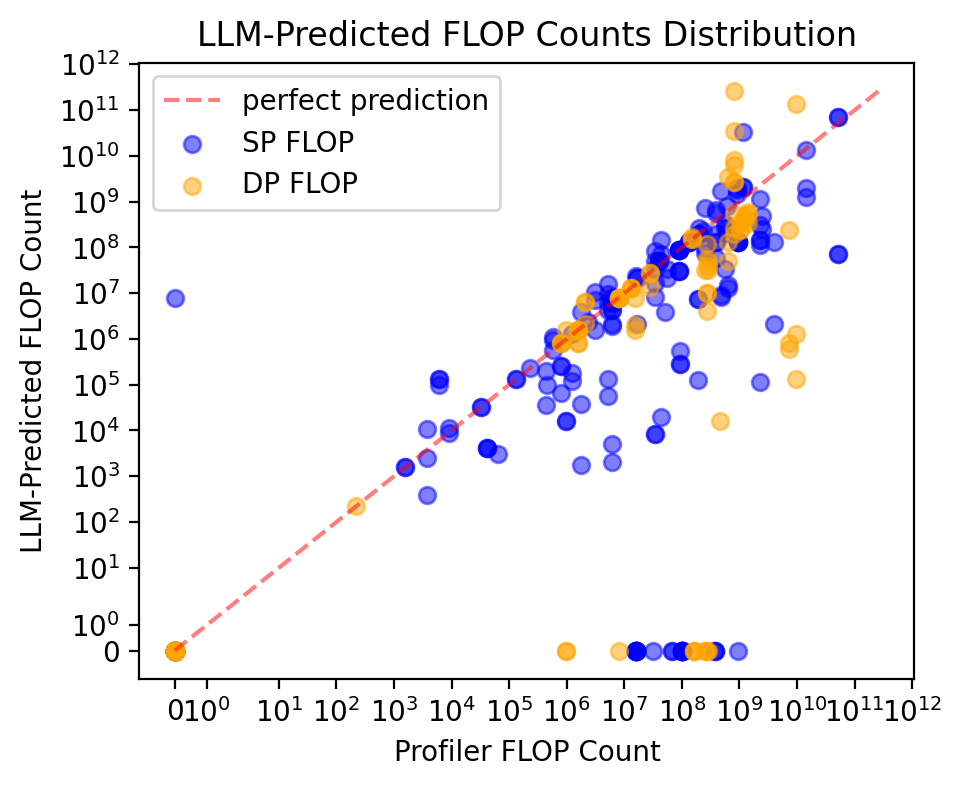

In [11]:
# now lets make a scatter plot of the predicted SP vs DP FLOP counts
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=200)

max_sp_dp_flop = max(
    success_df['empirical_sp_flop_count'].max(),
    success_df['empirical_dp_flop_count'].max(),
    success_df['sp_flop_predicted'].max(),
    success_df['dp_flop_predicted'].max()
)
min_sp_dp_flop = min(
    success_df['empirical_sp_flop_count'].min(),
    success_df['empirical_dp_flop_count'].min(),
    success_df['sp_flop_predicted'].min(),
    success_df['dp_flop_predicted'].min()
)

print(f"min_sp_dp_flop: {min_sp_dp_flop}, max_sp_dp_flop: {max_sp_dp_flop}")

# plot the x-y line on the plot
ax.plot([min_sp_dp_flop, max_sp_dp_flop], [min_sp_dp_flop, max_sp_dp_flop], color='red', linestyle='--', alpha=0.5, label='perfect prediction')

ax.scatter(success_df['empirical_sp_flop_count'], success_df['sp_flop_predicted'], alpha=0.5, label='SP FLOP', color='blue')
ax.scatter(success_df['empirical_dp_flop_count'], success_df['dp_flop_predicted'], alpha=0.5, label='DP FLOP', color='orange')


ax.set_xscale('symlog')
ax.set_yscale('symlog')

#ax.set_xlim(min_sp_dp_flop-100, max_sp_dp_flop)
#ax.set_ylim(min_sp_dp_flop-100, max_sp_dp_flop)
ax.set_title('LLM-Predicted FLOP Counts Distribution')
plt.xlabel('Profiler FLOP Count')
plt.ylabel('LLM-Predicted FLOP Count')
plt.legend()
plt.show()


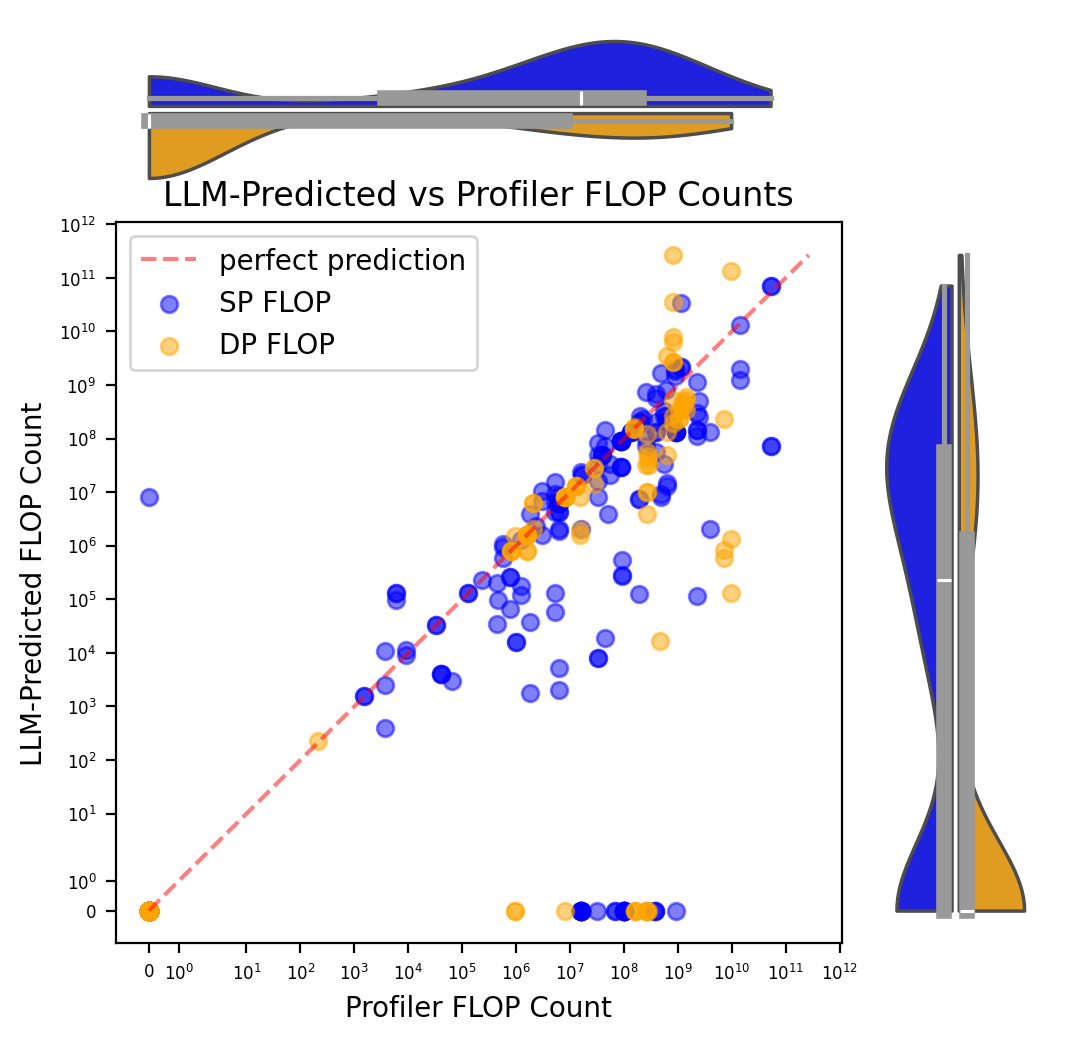

In [12]:
# ...existing code above...
import seaborn as sns
from matplotlib import gridspec

# now let's make a scatter plot with marginal violin plots
fig = plt.figure(figsize=(6, 6), dpi=200)
gs = gridspec.GridSpec(2, 2,
                       width_ratios=(4, 1),
                       height_ratios=(1, 4),
                       wspace=0.05,
                       hspace=0.05)

ax_main = fig.add_subplot(gs[1, 0])
ax_x = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_y = fig.add_subplot(gs[1, 1], sharey=ax_main)

# main scatter and identity line
ax_main.plot([min_sp_dp_flop, max_sp_dp_flop],
             [min_sp_dp_flop, max_sp_dp_flop],
             color='red', linestyle='--', alpha=0.5, label='perfect prediction')
ax_main.scatter(success_df['empirical_sp_flop_count'],
                success_df['sp_flop_predicted'],
                alpha=0.5, label='SP FLOP', color='blue')
ax_main.scatter(success_df['empirical_dp_flop_count'],
                success_df['dp_flop_predicted'],
                alpha=0.5, label='DP FLOP', color='orange')
ax_main.set_xscale('symlog')
ax_main.set_yscale('symlog')
ax_main.set_xlabel('Profiler FLOP Count')
ax_main.set_ylabel('LLM-Predicted FLOP Count')
ax_main.legend(loc='upper left')
ax_main.tick_params(axis='both', which='major', labelsize=6)
ax_main.set_title("LLM-Predicted vs Profiler FLOP Counts")

# top margin violins for empirical counts
df_emp = success_df[['empirical_sp_flop_count','empirical_dp_flop_count']] \
          .melt(var_name='type', value_name='count')
sns.violinplot(x='count', hue='type', data=df_emp, orient='h',
               palette={'empirical_sp_flop_count':'blue',
                        'empirical_dp_flop_count':'orange'},
               ax=ax_x, legend=False, inner='box', split=True, gap=0.1, cut=0, inner_kws={'color': ".6"})
ax_x.set_xscale('symlog')
ax_x.axis('off')

# right margin violins for predicted counts
df_pred = success_df[['sp_flop_predicted','dp_flop_predicted']] \
           .melt(var_name='type', value_name='count')
sns.violinplot(hue='type', y='count', data=df_pred, orient='v',
               palette={'sp_flop_predicted':'blue',
                        'dp_flop_predicted':'orange'},
               ax=ax_y, legend=False, inner='box', split=True, gap=0.1, cut=0, inner_kws={'color': ".6"})
ax_y.set_yscale('symlog')
ax_y.axis('off')

plt.show()
# ...existing

In [13]:
# depending on the scale of the empirical flop counts, the percent difference can be very large
# for a prediction that is rather close to the empirical value
# for example: if the empirical count is 3000 and the prediction is 6000, the percent difference is 100%
# but the order of magnitude of the prediction is still pretty close to the empirical value

# in order to account for this, we can take the log of the empirical and predicted counts
# and then compute the percent difference in log space
# this way, a prediction of 6000 for an empirical count of 3000 will

In [14]:
def print_perc_error(percent):
    # let's count the codes that have less than 50% error in either SP or DP FLOP count prediction
    sp_50pct_err = nnz_sp_flop_df[nnz_sp_flop_df['sp_flop_perc_diff'].abs() <= percent]
    dp_50pct_err = nnz_dp_flop_df[nnz_dp_flop_df['dp_flop_perc_diff'].abs() <= percent]

    print(f"Number of nonzero SP-FLOP codes with <= {percent}% SP FLOP error: {len(sp_50pct_err)} out of {len(nnz_sp_flop_df)} ({len(sp_50pct_err)/len(nnz_sp_flop_df)*100:.2f}%)")
    print(f"Number of nonzero DP-FLOP codes with <= {percent}% DP FLOP error: {len(dp_50pct_err)} out of {len(nnz_dp_flop_df)} ({len(dp_50pct_err)/len(nnz_dp_flop_df)*100:.2f}%)")
    print()

In [15]:
print_perc_error(95)
print_perc_error(50)
print_perc_error(25)
print_perc_error(10)
print_perc_error(5)

Number of nonzero SP-FLOP codes with <= 95% SP FLOP error: 108 out of 176 (61.36%)
Number of nonzero DP-FLOP codes with <= 95% DP FLOP error: 49 out of 78 (62.82%)

Number of nonzero SP-FLOP codes with <= 50% SP FLOP error: 55 out of 176 (31.25%)
Number of nonzero DP-FLOP codes with <= 50% DP FLOP error: 27 out of 78 (34.62%)

Number of nonzero SP-FLOP codes with <= 25% SP FLOP error: 39 out of 176 (22.16%)
Number of nonzero DP-FLOP codes with <= 25% DP FLOP error: 22 out of 78 (28.21%)

Number of nonzero SP-FLOP codes with <= 10% SP FLOP error: 33 out of 176 (18.75%)
Number of nonzero DP-FLOP codes with <= 10% DP FLOP error: 21 out of 78 (26.92%)

Number of nonzero SP-FLOP codes with <= 5% SP FLOP error: 31 out of 176 (17.61%)
Number of nonzero DP-FLOP codes with <= 5% DP FLOP error: 21 out of 78 (26.92%)



In [16]:
# let's add in the byte counts from our oracle, this is like asking: "if we have a perfect byte count predictor, how bad would the arithmetic intensity predictions be?"
# we would like to see how the AI classifications would be with these FLOP estimates

from utils.dataset import df as df_oracle

In [17]:
# xtime is in units of nanoseconds, need to scale up to seconds

df_oracle['byte_count'] = df_oracle['traffic'] * 1e-9 * df_oracle['xtime']

# we know that for fdtd3d-cuda, finite_difference
# the SP-FLOP count is 188510085
# if our math is correct, we should be able to get that same value with our byte count

# the index is already set to the combined_name, so we can just access it directly
test_sample = df_oracle[df_oracle['combined_name'] == '(fdtd3d-cuda, finite_difference)']
assert test_sample.shape[0] == 1

test_sample = test_sample.iloc[0]

# this should yield the SP_FLOP we have in the dataset
result = int(test_sample['spAI'] * test_sample['byte_count'])
assert result == 188510085, f"Expected 188510085, got {result}"
assert result == test_sample['SP_FLOP'], f"Expected {test_sample['SP_FLOP']}, got {result}"


In [18]:
# set the index to be the combined_name column
df_oracle.set_index('combined_name', inplace=True)
success_df.set_index('combined_name', inplace=True)

success_df['byte_count'] = df_oracle['byte_count']

df_oracle.reset_index(inplace=True, drop=True)
success_df.reset_index(inplace=True, drop=True)


/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_16746/2162383291.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  success_df['byte_count'] = df_oracle['byte_count']


In [19]:
# now that we have the byte counts, we can make the predicted AI values

success_df['predicted_sp_ai'] = success_df['sp_flop_predicted'] / success_df['byte_count']
success_df['predicted_dp_ai'] = success_df['dp_flop_predicted'] / success_df['byte_count']

success_df['empirical_sp_ai'] = success_df['empirical_sp_flop_count'] / success_df['byte_count']
success_df['empirical_dp_ai'] = success_df['empirical_dp_flop_count'] / success_df['byte_count']


/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_16746/1098432303.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  success_df['predicted_sp_ai'] = success_df['sp_flop_predicted'] / success_df['byte_count']
/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_16746/1098432303.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  success_df['predicted_dp_ai'] = success_df['dp_flop_predicted'] / success_df['byte_count']
/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_16746/109843230

In [20]:
# GPU specs

# you can get this from deviceQuery
gpuName = 'NVIDIA RTX 3080'

# you can call nvidia-smi -i 0 -q to see what the clock is set to 
# you can also set the clock with nvidia-smi -lgc 1440,1440 for consistent measurements
# vendor specs show the base clock
baseClockHz = 1.440e9

# find these values here: https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#arithmetic-instructions
SPinstPerCyclePerSM = 128
DPinstPerCyclePerSM = 2
intInstPerCyclePerSM = 64

# find this in deviceQuery or GPU vendor specs
numSMs = 68

# we always assume you're doing FMA 
numFMAopPerInst = 2

# conversion multiplier
tflopPerflop = 1e-12

# get this from your GPU vendor specs, mine was 760.3 GB/s
maxBandwidthTBPerSec = 0.7603

spOPMaxPerfTFLOP = SPinstPerCyclePerSM * numSMs * baseClockHz * numFMAopPerInst * tflopPerflop
dpOPMaxPerfTFLOP = DPinstPerCyclePerSM * numSMs * baseClockHz * numFMAopPerInst * tflopPerflop
intOPMaxPerfTFLOP = intInstPerCyclePerSM * numSMs * baseClockHz * numFMAopPerInst * tflopPerflop

spOPMaxPerfTFLOP_noFMA = spOPMaxPerfTFLOP / 2
dpOPMaxPerfTFLOP_noFMA = dpOPMaxPerfTFLOP / 2

print('Max SP TFLOP/s with FMA', round(spOPMaxPerfTFLOP, 3))
print('Max DP TFLOP/s with FMA', round(dpOPMaxPerfTFLOP, 3))
print('Max SP TFLOP/s w/out FMA', round(spOPMaxPerfTFLOP_noFMA, 3))
print('Max DP TFLOP/s w/out FMA', round(dpOPMaxPerfTFLOP_noFMA, 3))
print('Max TINTOP/s', round(intOPMaxPerfTFLOP, 3))

balancePointSPFLOPPerByte = spOPMaxPerfTFLOP / maxBandwidthTBPerSec
balancePointDPFLOPPerByte = dpOPMaxPerfTFLOP / maxBandwidthTBPerSec
balancePointINTOPPerByte = intOPMaxPerfTFLOP / maxBandwidthTBPerSec
print(f'SP Balance Point is at: {round(balancePointSPFLOPPerByte, 2)} flop/byte')
print(f'DP Balance Point is at: {round(balancePointDPFLOPPerByte, 2)} flop/byte')
print(f'INT Balance Point is at: {round(balancePointINTOPPerByte, 2)} intop/byte')

Max SP TFLOP/s with FMA 25.068
Max DP TFLOP/s with FMA 0.392
Max SP TFLOP/s w/out FMA 12.534
Max DP TFLOP/s w/out FMA 0.196
Max TINTOP/s 12.534
SP Balance Point is at: 32.97 flop/byte
DP Balance Point is at: 0.52 flop/byte
INT Balance Point is at: 16.49 intop/byte


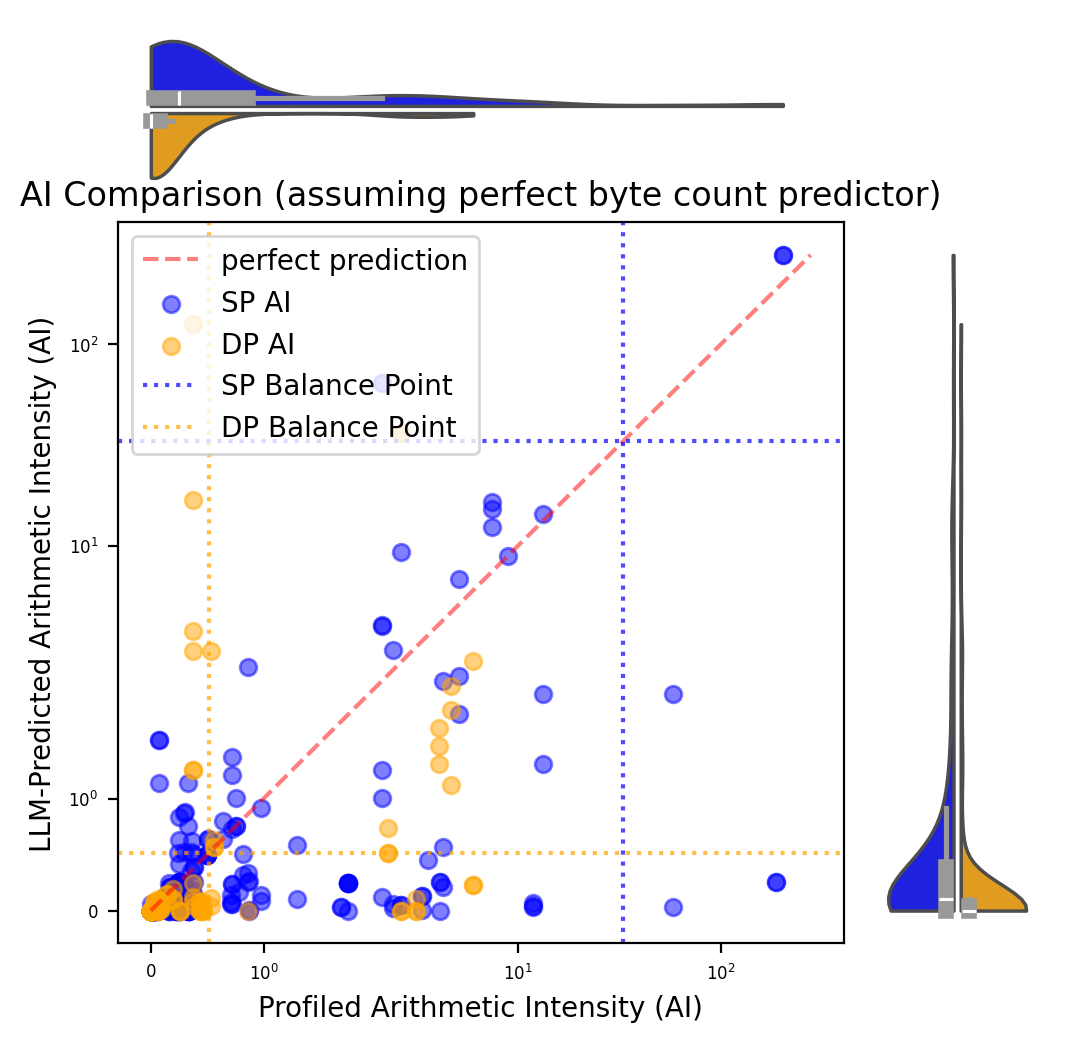

In [21]:
# now let's make a scatter plot of the predicted SP/DP AI values and the empirical SP/DP AI values

# now let's make a scatter plot with marginal violin plots
fig = plt.figure(figsize=(6, 6), dpi=200)
gs = gridspec.GridSpec(2, 2,
                       width_ratios=(4, 1),
                       height_ratios=(1, 4),
                       wspace=0.05,
                       hspace=0.05)

ax_main = fig.add_subplot(gs[1, 0])
ax_x = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_y = fig.add_subplot(gs[1, 1], sharey=ax_main)

min_sp_ai = min(success_df['predicted_sp_ai'].min(),
                 success_df['predicted_dp_ai'].min(),
                 success_df['empirical_sp_ai'].min(),
                 success_df['empirical_dp_ai'].min())

max_sp_ai = max(success_df['predicted_sp_ai'].max(),
                 success_df['predicted_dp_ai'].max(),
                 success_df['empirical_sp_ai'].max(),
                 success_df['empirical_dp_ai'].max())

# main scatter and identity line
ax_main.plot([min_sp_ai, max_sp_ai],
             [min_sp_ai, max_sp_ai],
             color='red', linestyle='--', alpha=0.5, label='perfect prediction')
ax_main.scatter(success_df['empirical_sp_ai'],
                success_df['predicted_sp_ai'],
                alpha=0.5, label='SP AI', color='blue')
ax_main.scatter(success_df['empirical_dp_ai'],
                success_df['predicted_dp_ai'],
                alpha=0.5, label='DP AI', color='orange')

ax_main.axvline(x=balancePointSPFLOPPerByte, color='blue', linestyle=':', alpha=0.7, label='SP Balance Point')
ax_main.axvline(x=balancePointDPFLOPPerByte, color='orange', linestyle=':', alpha=0.7, label='DP Balance Point')
ax_main.axhline(y=balancePointSPFLOPPerByte, color='blue', linestyle=':', alpha=0.7)
ax_main.axhline(y=balancePointDPFLOPPerByte, color='orange', linestyle=':', alpha=0.7)

ax_main.set_xscale('symlog')
ax_main.set_yscale('symlog')
ax_main.set_xlabel('Profiled Arithmetic Intensity (AI)')
ax_main.set_ylabel('LLM-Predicted Arithmetic Intensity (AI)')
ax_main.legend(loc='upper left')
ax_main.tick_params(axis='both', which='major', labelsize=6)
ax_main.set_title('AI Comparison (assuming perfect byte count predictor)')


# top margin violins for empirical counts
df_emp = success_df[['empirical_sp_ai','empirical_dp_ai']] \
          .melt(var_name='type', value_name='count')
sns.violinplot(x='count', hue='type', data=df_emp, orient='h',
               palette={'empirical_sp_ai':'blue',
                        'empirical_dp_ai':'orange'},
               ax=ax_x, legend=False, inner='box', split=True, gap=0.1, cut=0, inner_kws={'color': ".6"})
ax_x.set_xscale('symlog')
ax_x.axis('off')

# right margin violins for predicted counts
df_pred = success_df[['predicted_sp_ai','predicted_dp_ai']] \
           .melt(var_name='type', value_name='count')
sns.violinplot(hue='type', y='count', data=df_pred, orient='v',
               palette={'predicted_sp_ai':'blue',
                        'predicted_dp_ai':'orange'},
               ax=ax_y, legend=False, inner='box', split=True, gap=0.1, cut=0, inner_kws={'color': ".6"})
ax_y.set_yscale('symlog')
ax_y.axis('off')

plt.show()
# ...existing

In [22]:
# calculate the arithmetic intensity classifications

success_df['true_ai_class_sp'] = success_df['empirical_sp_ai'].apply(lambda x: 'BB' if x < balancePointSPFLOPPerByte else 'CB')
success_df['pred_ai_class_sp'] = success_df['predicted_sp_ai'].apply(lambda x: 'BB' if x < balancePointSPFLOPPerByte else 'CB')
success_df['is_pred_correct_sp'] = success_df['true_ai_class_sp'] == success_df['pred_ai_class_sp']

success_df['true_ai_class_dp'] = success_df['empirical_dp_ai'].apply(lambda x: 'BB' if x < balancePointDPFLOPPerByte else 'CB')
success_df['pred_ai_class_dp'] = success_df['predicted_dp_ai'].apply(lambda x: 'BB' if x < balancePointDPFLOPPerByte else 'CB')
success_df['is_pred_correct_dp'] = success_df['true_ai_class_dp'] == success_df['pred_ai_class_dp']

/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_16746/2643684624.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  success_df['true_ai_class_sp'] = success_df['empirical_sp_ai'].apply(lambda x: 'BB' if x < balancePointSPFLOPPerByte else 'CB')
/var/folders/3g/gqtlwym54qj00m_k586jkf0w0000gn/T/ipykernel_16746/2643684624.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  success_df['pred_ai_class_sp'] = success_df['predicted_sp_ai'].apply(lambda x: 'BB' if x < balancePointSPFLOPPerByte else 'CB')


In [23]:
# let's print the percentage of correct classifications

sp_correct = success_df['is_pred_correct_sp'].sum()
sp_len = success_df.shape[0]
print(f"Percentage of SP AI predictions that are correct: {sp_correct} / {sp_len} = {sp_correct / sp_len * 100:.2f}%")

dp_correct = success_df['is_pred_correct_dp'].sum()
dp_len = success_df.shape[0]
print(f"Percentage of DP AI predictions that are correct: {dp_correct} / {dp_len} = {dp_correct / dp_len * 100:.2f}%")

Percentage of SP AI predictions that are correct: 224 / 229 = 97.82%
Percentage of DP AI predictions that are correct: 213 / 229 = 93.01%


In [24]:
nnz_sp_flop_df = success_df[success_df['empirical_sp_flop_count'] > 0]
nnz_dp_flop_df = success_df[success_df['empirical_dp_flop_count'] > 0]

In [25]:
nnz_sp_correct = nnz_sp_flop_df['is_pred_correct_sp'].sum()
nnz_sp_len = nnz_sp_flop_df.shape[0]
print(f"Number of nonzero SP FLOP codes with correct AI prediction: {nnz_sp_correct} out of {nnz_sp_len} = {nnz_sp_correct / nnz_sp_len * 100:.2f}%")

nnz_dp_correct = nnz_dp_flop_df['is_pred_correct_dp'].sum()
nnz_dp_len = nnz_dp_flop_df.shape[0]
print(f"Number of nonzero DP FLOP codes with correct AI prediction: {nnz_dp_correct} out of {nnz_dp_len} = {nnz_dp_correct / nnz_dp_len * 100:.2f}%")

Number of nonzero SP FLOP codes with correct AI prediction: 171 out of 176 = 97.16%
Number of nonzero DP FLOP codes with correct AI prediction: 62 out of 78 = 79.49%


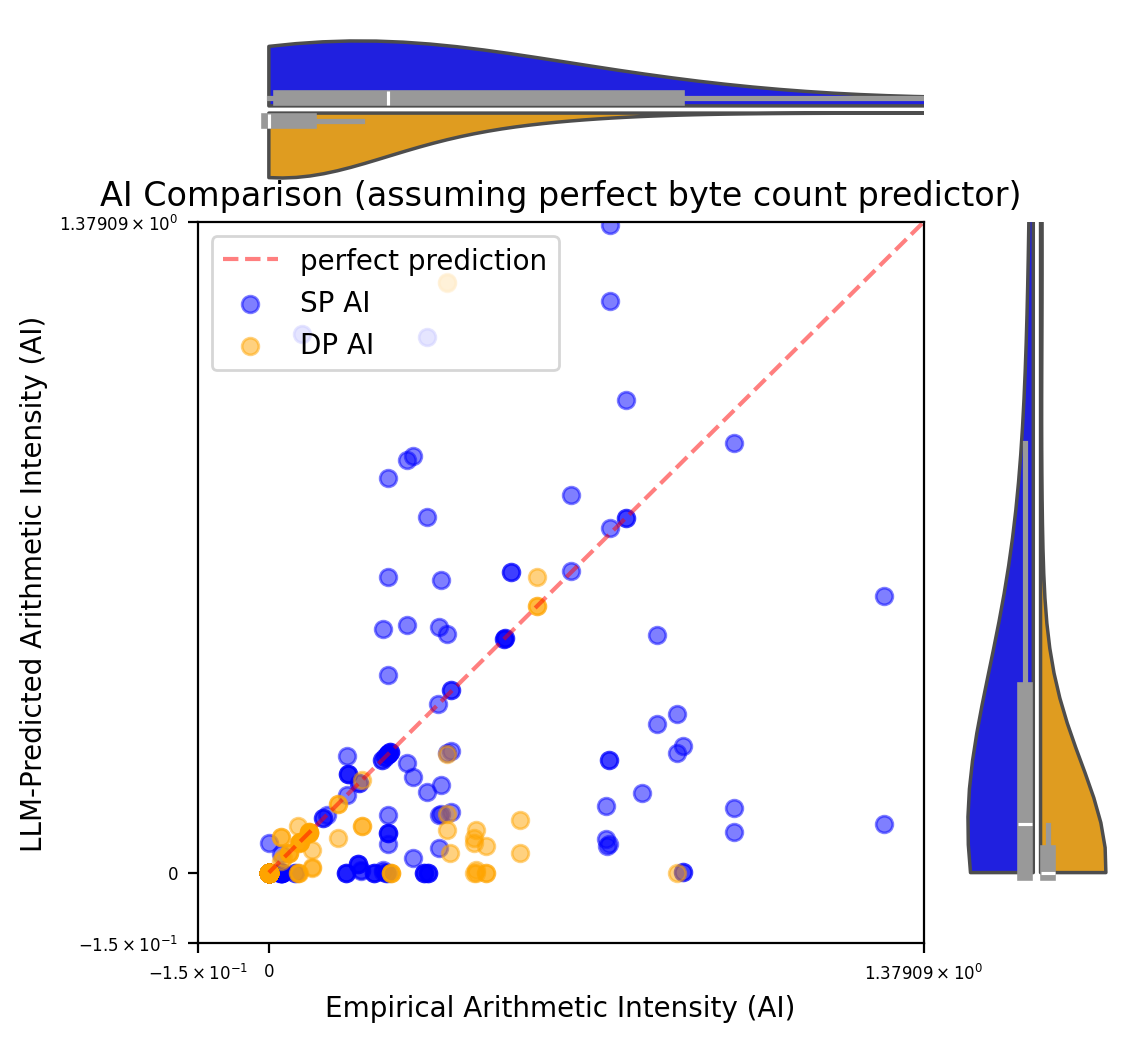

In [26]:
# now let's make a scatter plot of the predicted SP/DP AI values and the empirical SP/DP AI values

# now let's make a scatter plot with marginal violin plots
fig = plt.figure(figsize=(6, 6), dpi=200)
gs = gridspec.GridSpec(2, 2,
                       width_ratios=(4, 1),
                       height_ratios=(1, 4),
                       wspace=0.05,
                       hspace=0.05)

ax_main = fig.add_subplot(gs[1, 0])
ax_x = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_y = fig.add_subplot(gs[1, 1], sharey=ax_main)

min_sp_ai = min(success_df['predicted_sp_ai'].min(),
                 success_df['predicted_dp_ai'].min(),
                 success_df['empirical_sp_ai'].min(),
                 success_df['empirical_dp_ai'].min()) / 200
max_sp_ai = max(success_df['predicted_sp_ai'].max(),
                 success_df['predicted_dp_ai'].max(),
                 success_df['empirical_sp_ai'].max(),
                 success_df['empirical_dp_ai'].max()) / 200

# main scatter and identity line
ax_main.plot([min_sp_ai, max_sp_ai],
             [min_sp_ai, max_sp_ai],
             color='red', linestyle='--', alpha=0.5, label='perfect prediction')
ax_main.scatter(success_df['empirical_sp_ai'],
                success_df['predicted_sp_ai'],
                alpha=0.5, label='SP AI', color='blue')
ax_main.scatter(success_df['empirical_dp_ai'],
                success_df['predicted_dp_ai'],
                alpha=0.5, label='DP AI', color='orange')
ax_main.set_xscale('symlog')
ax_main.set_yscale('symlog')
ax_main.set_xlabel('Empirical Arithmetic Intensity (AI)')
ax_main.set_ylabel('LLM-Predicted Arithmetic Intensity (AI)')
ax_main.legend(loc='upper left')
ax_main.tick_params(axis='both', which='major', labelsize=6)
ax_main.set_title('AI Comparison (assuming perfect byte count predictor)')
ax_main.set_xlim((min_sp_ai-0.15, max_sp_ai))
ax_main.set_ylim((min_sp_ai-0.15, max_sp_ai))

# top margin violins for empirical counts
df_emp = success_df[['empirical_sp_ai','empirical_dp_ai']] \
          .melt(var_name='type', value_name='count')
sns.violinplot(x='count', hue='type', data=df_emp, orient='h',
               palette={'empirical_sp_ai':'blue',
                        'empirical_dp_ai':'orange'},
               ax=ax_x, legend=False, inner='box', split=True, gap=0.1, cut=0, inner_kws={'color': ".6"})
ax_x.set_xscale('symlog')
ax_x.axis('off')

# right margin violins for predicted counts
df_pred = success_df[['predicted_sp_ai','predicted_dp_ai']] \
           .melt(var_name='type', value_name='count')
sns.violinplot(hue='type', y='count', data=df_pred, orient='v',
               palette={'predicted_sp_ai':'blue',
                        'predicted_dp_ai':'orange'},
               ax=ax_y, legend=False, inner='box', split=True, gap=0.1, cut=0, inner_kws={'color': ".6"})
ax_y.set_yscale('symlog')
ax_y.axis('off')

plt.show()
# ...existing